Demonstration of Beta Regression Concepts for Child Face Recognition
===================================================================
This script demonstrates how beta regression could address limitations
in current linear modeling approaches. It uses published values from
Deb et al. (2018) and Bahmani et al. (2023) to illustrate concepts.

IMPORTANT: This is a methodological demonstration, not a validation.
Actual implementation requires access to the original datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [3]:
# Published values from the papers
CLF_RESULTS = {
    'degradation_rates': {
        'COTS-A': 0.2234,  # SD/year from Deb et al. 2018
        'FaceNet': 0.2180,
        'Fused': 0.2444
    },
    'performance': {
        # TAR at 0.1% FAR (from Table 3a in Deb et al.)
        'COTS-A': {1: 81.94, 3: 49.33},
        'FaceNet': {1: 83.77, 3: 59.80},
        'Fused': {1: 90.18, 3: 73.33}
    }
}

In [4]:
YFA_RESULTS = {
    # From Bahmani et al. 2023
    'overall_performance': {
        2: 98.52,  # years: TAR%
        4: 95.68,
        6: 87.24,
        8: 71.32
    },
    'age_groups': {
        # Approximate values from their heatmap
        '3-5': {'initial': 97.8, 'final': 63.1},
        '5.5-7': {'initial': 97.9, 'final': 80.2},
        '7.5-9': {'initial': 98.3, 'final': 65.6}
    }
}

In [5]:
def demonstrate_linear_model_issues():
    """Show how linear models violate probability bounds"""

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Left panel: Linear extrapolation problem
    ax1 = axes[0]
    years = np.linspace(0, 15, 100)

    # Using CLF Fused algorithm parameters
    initial_tar = 100  # Starting at 100%
    degradation_rate = 24.44  # 0.2444 SD/year ≈ 24.44%/year for TAR

    # Linear prediction
    linear_pred = initial_tar - degradation_rate * years

    ax1.plot(years, linear_pred, 'r-', linewidth=2, label='Linear Model')
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax1.axhline(y=100, color='k', linestyle='--', alpha=0.5)
    ax1.fill_between(years, -20, 0, alpha=0.2, color='red',
                     label='Impossible Region')
    ax1.fill_between(years, 100, 120, alpha=0.2, color='red')

    # Add actual data points
    for year, tar in CLF_RESULTS['performance']['Fused'].items():
        ax1.plot(year, tar, 'ko', markersize=10)

    ax1.set_xlabel('Years Since Enrollment')
    ax1.set_ylabel('True Accept Rate (%)')
    ax1.set_title('Linear Model Boundary Violations')
    ax1.legend()
    ax1.set_ylim(-20, 120)

    # Right panel: Variance assumption problem
    ax2 = axes[1]
    tar_values = np.linspace(0.01, 0.99, 100)

    # Linear model assumes constant variance
    linear_variance = np.ones_like(tar_values) * 0.15

    # Beta distribution variance: μ(1-μ)/(1+φ)
    phi = 50  # precision parameter
    beta_variance = tar_values * (1 - tar_values) / (1 + phi)

    ax2.plot(tar_values * 100, linear_variance, 'r-', linewidth=2,
             label='Linear Model Assumption')
    ax2.plot(tar_values * 100, beta_variance, 'g-', linewidth=2,
             label='Beta Distribution')

    ax2.set_xlabel('True Accept Rate (%)')
    ax2.set_ylabel('Variance')
    ax2.set_title('Variance Assumptions')
    ax2.legend()

    plt.tight_layout()
    return fig

In [6]:
def demonstrate_age_patterns():
    """Show non-linear patterns from YFA study"""

    fig, ax = plt.subplots(figsize=(10, 6))

    # Time points from YFA (6-month intervals up to 8 years)
    time_points = np.arange(0.5, 8.5, 0.5)

    # Simulate the three distinct patterns observed
    # Pattern 1: Steep decline (ages 3-5)
    steep_decline = 97.8 * np.exp(-0.15 * time_points)
    steep_decline = np.maximum(steep_decline, 63.1)  # Floor at observed minimum

    # Pattern 2: Stable (ages 5.5-7)
    stable = 97.9 - 2.2 * time_points  # Very gradual decline
    stable = np.maximum(stable, 80.2)

    # Pattern 3: Intermediate (ages 7.5-9)
    intermediate = 98.3 * (1 - 0.04 * time_points) ** 2
    intermediate = np.maximum(intermediate, 65.6)

    ax.plot(time_points, steep_decline, 'r-', linewidth=2,
            label='Ages 3-5 (Steep Decline)')
    ax.plot(time_points, stable, 'g-', linewidth=2,
            label='Ages 5.5-7 (Stable)')
    ax.plot(time_points, intermediate, 'b-', linewidth=2,
            label='Ages 7.5-9 (Intermediate)')

    # Add shaded regions for different developmental phases
    ax.axvspan(0, 2, alpha=0.1, color='yellow', label='Initial Period')
    ax.axvspan(2, 5, alpha=0.1, color='orange', label='Transition')
    ax.axvspan(5, 8, alpha=0.1, color='red', label='Long-term')

    ax.set_xlabel('Years Since Enrollment')
    ax.set_ylabel('True Accept Rate (%)')
    ax.set_title('Age-Specific Degradation Patterns from YFA Study')
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(60, 100)

    plt.tight_layout()
    return fig

In [7]:
def beta_regression_concept():
    """Demonstrate beta regression concepts"""

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Panel 1: Beta distribution shapes
    ax1 = axes[0, 0]
    x = np.linspace(0.001, 0.999, 1000)

    # Different parameter combinations
    params = [
        (0.9, 50, 'High performance (μ=0.9, φ=50)'),
        (0.7, 30, 'Medium performance (μ=0.7, φ=30)'),
        (0.5, 20, 'Low performance (μ=0.5, φ=20)')
    ]

    for mu, phi, label in params:
        alpha = mu * phi
        beta = (1 - mu) * phi
        y = stats.beta.pdf(x, alpha, beta)
        ax1.plot(x, y, linewidth=2, label=label)

    ax1.set_xlabel('True Accept Rate')
    ax1.set_ylabel('Density')
    ax1.set_title('Beta Distribution for Different Performance Levels')
    ax1.legend()

    # Panel 2: Link function
    ax2 = axes[0, 1]
    linear_predictor = np.linspace(-4, 4, 100)
    probability = expit(linear_predictor)

    ax2.plot(linear_predictor, probability * 100, 'b-', linewidth=2)
    ax2.set_xlabel('Linear Predictor (logit scale)')
    ax2.set_ylabel('True Accept Rate (%)')
    ax2.set_title('Logit Link Function Ensures Bounded Predictions')
    ax2.grid(True, alpha=0.3)

    # Panel 3: Spline basis for age
    ax3 = axes[1, 0]
    ages = np.linspace(3, 18, 100)

    # Simple cubic spline basis (conceptual)
    knots = [5, 11, 14]
    for i, knot in enumerate(knots):
        basis = np.maximum(0, (ages - knot)**3)
        basis = basis / np.max(basis) if np.max(basis) > 0 else basis
        ax3.plot(ages, basis, linewidth=2, label=f'Knot at age {knot}')

    ax3.set_xlabel('Enrollment Age (years)')
    ax3.set_ylabel('Spline Basis Value')
    ax3.set_title('Spline Basis Functions for Age Effects')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Panel 4: Predicted trajectories
    ax4 = axes[1, 1]
    time_gap = np.linspace(0, 8, 100)

    # Conceptual beta regression predictions for different age groups
    # These would come from the fitted model in practice
    age_3_5 = expit(2.5 - 0.4 * time_gap - 0.05 * time_gap**2) * 100
    age_5_7 = expit(2.8 - 0.15 * time_gap) * 100
    age_10_12 = expit(3.0 - 0.25 * time_gap - 0.03 * time_gap**2) * 100

    ax4.plot(time_gap, age_3_5, 'r-', linewidth=2, label='Ages 3-5')
    ax4.plot(time_gap, age_5_7, 'g-', linewidth=2, label='Ages 5.5-7')
    ax4.plot(time_gap, age_10_12, 'b-', linewidth=2, label='Ages 10-12')

    # Add confidence bands (conceptual)
    ax4.fill_between(time_gap, age_5_7 - 5, age_5_7 + 5,
                     alpha=0.2, color='green')

    ax4.set_xlabel('Years Since Enrollment')
    ax4.set_ylabel('Predicted TAR (%)')
    ax4.set_title('Beta Regression Predictions (Conceptual)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(50, 100)

    plt.tight_layout()
    return fig

In [8]:
def create_comparison_table():
    """Create comparison of modeling approaches"""

    comparison_data = {
        'Aspect': [
            'Predictions bounded to [0,1]',
            'Handles heteroscedasticity',
            'Captures non-linear patterns',
            'Interpretable parameters',
            'Software availability',
            'Computational complexity'
        ],
        'Linear Mixed Model': [
            'No (requires post-hoc truncation)',
            'No (assumes constant variance)',
            'Limited (without complex interactions)',
            'Yes (change per unit time)',
            'Excellent (lme4, nlme)',
            'Low'
        ],
        'Beta Regression': [
            'Yes (inherently)',
            'Yes (automatic)',
            'Yes (with splines)',
            'Yes (log-odds scale)',
            'Good (glmmTMB, brms)',
            'Moderate'
        ]
    }

    df = pd.DataFrame(comparison_data)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='left',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Color coding
    for i in range(1, len(df) + 1):
        # Beta regression advantages in green
        if i in [1, 2, 3]:
            table[(i, 2)].set_facecolor('#90EE90')
        # Linear model advantages in light blue
        if i == 5:
            table[(i, 1)].set_facecolor('#ADD8E6')

    plt.title('Comparison of Modeling Approaches', fontsize=14, pad=20)
    return fig

In [9]:
def main():
    """Run all demonstrations"""

    print("Beta Regression for Child Face Recognition")
    print("=" * 50)
    print("\nThis script demonstrates concepts only.")
    print("Actual implementation requires the original datasets.")
    print("\nCreating visualizations...\n")

    # Create all figures
    fig1 = demonstrate_linear_model_issues()
    plt.savefig('linear_model_issues.png', dpi=300, bbox_inches='tight')
    print("✓ Created: linear_model_issues.png")

    fig2 = demonstrate_age_patterns()
    plt.savefig('age_patterns.png', dpi=300, bbox_inches='tight')
    print("✓ Created: age_patterns.png")

    fig3 = beta_regression_concept()
    plt.savefig('beta_regression_concepts.png', dpi=300, bbox_inches='tight')
    print("✓ Created: beta_regression_concepts.png")

    fig4 = create_comparison_table()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Created: model_comparison.png")

    print("\nKey Insights from the Literature:")
    print("-" * 50)
    print(f"• CLF Study: Linear degradation of {CLF_RESULTS['degradation_rates']['Fused']:.4f} SD/year")
    print(f"• YFA Study: TAR drops from {YFA_RESULTS['overall_performance'][2]:.1f}% to {YFA_RESULTS['overall_performance'][8]:.1f}% over 6 years")
    print(f"• Age 3-5: Steep decline from {YFA_RESULTS['age_groups']['3-5']['initial']:.1f}% to {YFA_RESULTS['age_groups']['3-5']['final']:.1f}%")
    print(f"• Age 5.5-7: Stable performance, maintaining {YFA_RESULTS['age_groups']['5.5-7']['final']:.1f}%")

    print("\nProposed Beta Regression Advantages:")
    print("-" * 50)
    print("• Respects probability bounds inherently")
    print("• Accommodates age-specific variance patterns")
    print("• Captures non-linear developmental trajectories")
    print("• Provides interpretable parameters on log-odds scale")

    print("\nNext Steps:")
    print("-" * 50)
    print("1. Obtain access to CLF or YFA datasets")
    print("2. Implement hierarchical beta regression models")
    print("3. Compare predictions with held-out data")
    print("4. Develop age-adaptive threshold recommendations")

    plt.show()

Beta Regression for Child Face Recognition

This script demonstrates concepts only.
Actual implementation requires the original datasets.

Creating visualizations...

✓ Created: linear_model_issues.png
✓ Created: age_patterns.png
✓ Created: beta_regression_concepts.png
✓ Created: model_comparison.png

Key Insights from the Literature:
--------------------------------------------------
• CLF Study: Linear degradation of 0.2444 SD/year
• YFA Study: TAR drops from 98.5% to 71.3% over 6 years
• Age 3-5: Steep decline from 97.8% to 63.1%
• Age 5.5-7: Stable performance, maintaining 80.2%

Proposed Beta Regression Advantages:
--------------------------------------------------
• Respects probability bounds inherently
• Accommodates age-specific variance patterns
• Captures non-linear developmental trajectories
• Provides interpretable parameters on log-odds scale

Next Steps:
--------------------------------------------------
1. Obtain access to CLF or YFA datasets
2. Implement hierarchical b

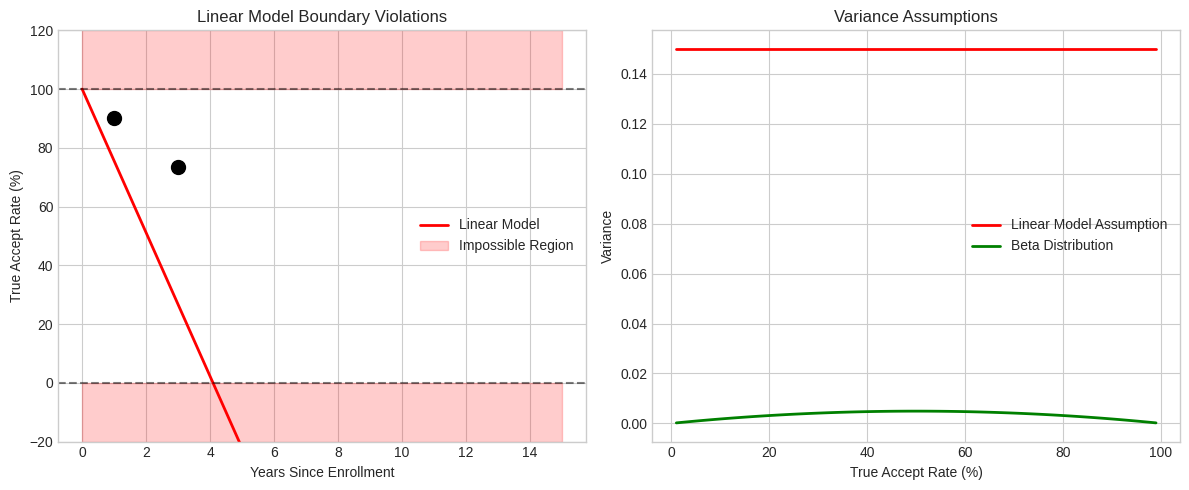

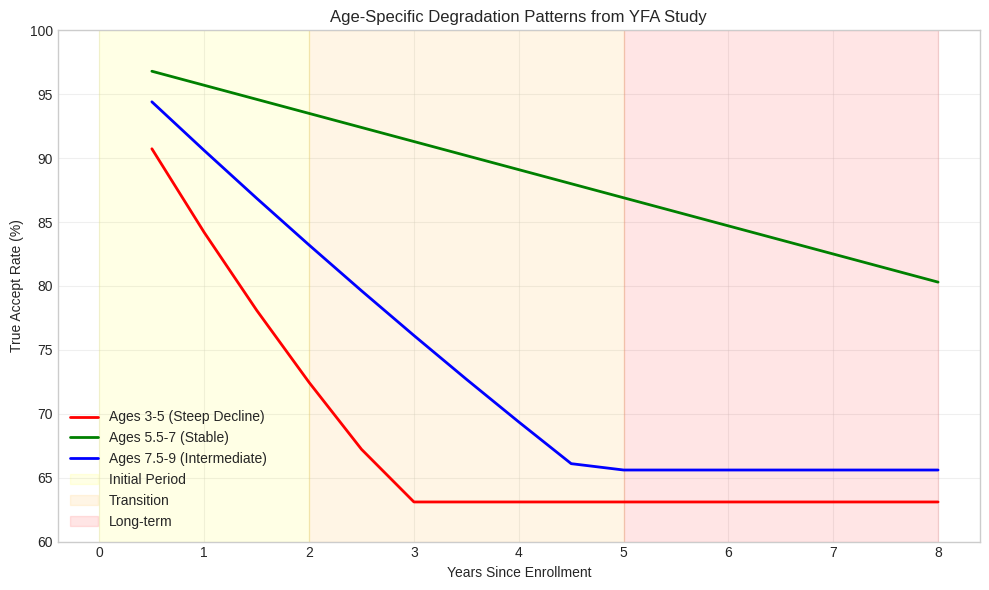

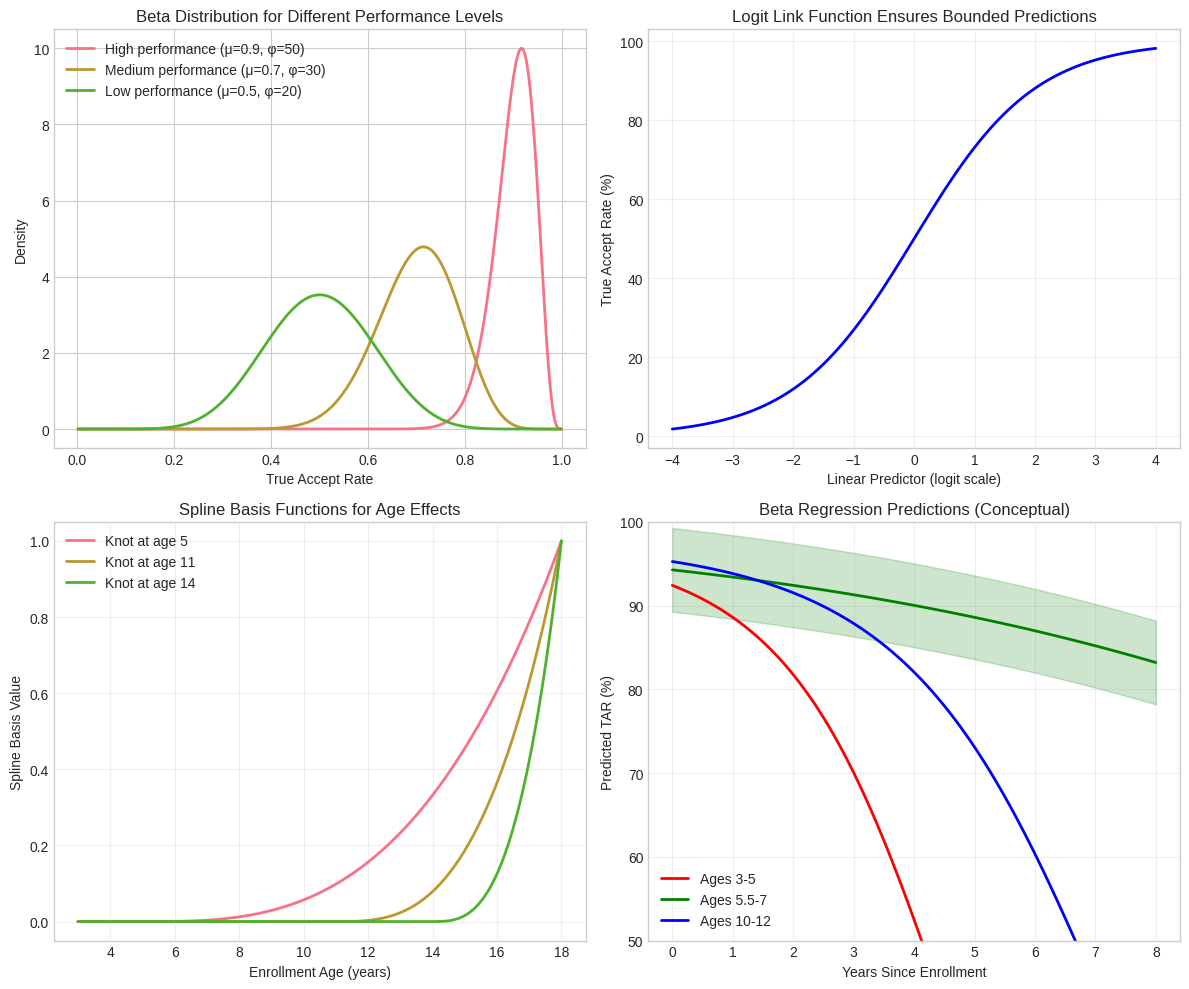

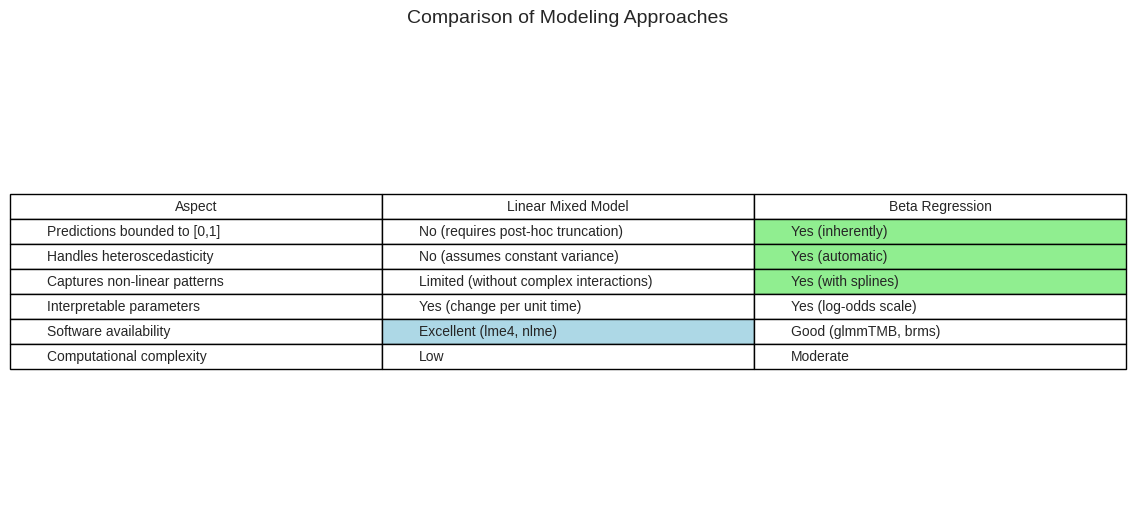

In [10]:
if __name__ == "__main__":
    main()